# 앙상블 학습과 랜덤 포레스트
* 일련의 예측기로 예측을 수집한다.
* 여러개의 결정트리를 쓰는 결정트리 앙상블을 랜덤 포레스트라고 한다.
* 배깅,부스팅,스태킹등 소개
---
### 투표 기반 분류기
* 여러개의 모델중 가장 많이 선택된 클래스를 선택하는 것을 직접투표 라고 한다.
* 가장 뛰어난 모델보돠 정확도가 높을 경우가 많다.
* 큰 수의 법칙으로 앞면이 51퍼센트인 동전을 1000번 하면 앞면이 다수가 될 확률은 75퍼센트 이다.
* 모든 분류기가 독립적이고 오차에 상관관계가 없어야하지만 같은 데이터로 훈련시키기 때문에 가정이 맞지 않다.
  * 분류기는 같은 종류의 오차를 만들기 쉽다.
  * 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다.
  *각기 다른 알고리즘으로 학습시키면 앗아블의 정확도가 높아진다.

In [104]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
x,y=datasets.make_moons(n_samples=1000,noise=0.4)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)


In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf=LogisticRegression()
rnd_clf=RandomForestClassifier()
svm_clf=SVC()
voting_clf=VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)],
    voting='hard'
)
voting_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [106]:
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
  clf.fit(x_train,y_train)
  y_pred=clf.predict(x_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.815
RandomForestClassifier 0.795
SVC 0.835
VotingClassifier 0.825


### 베깅과 페이스팅
* 중복해서 뽑는 방식을 배깅, 중복을 허용 안하면 페이스팅


In [107]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=500,
    max_samples=100,bootstrap=True,n_jobs=-1,
    oob_score=True
)
bag_clf.fit(x_train,y_train)
y_pred=bag_clf.predict(x_test)
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_pred))
bag_clf.oob_score_

BaggingClassifier 0.81


0.84375

### OOB 평가
* BaggingClassifier는 기본값으로 m개의 샘플을 선택한다. 이는 평균 63% 정도만 샘플링 된다는 것을 의미한다. 나머지 37%를 OOB라고 한다.
* BaggingClassifier의 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob평가를 수행한다. 이는 oob_score_변수에 저장되어 있다.

In [108]:
y_pred=bag_clf.predict(x_test)
accuracy_score(y_test,y_pred)

0.81

### 랜덤 패치와 랜덤 서브스페이스
* 배깅분류기는 특성 샘플링도 지원한다. 무작위로 입력한 특성의 일부분으로 훈련된다.
* 고차원 데이터셋에 유용하다.
* 특성과 샘플을 모두 샘플링하는 것을 램덤 패치 방식, 훈련샘플은 모두 사용하고 특성은 샘플링 하는것을 랜덤 서브 스페이스 방식.
---
### 랜덤 포레스트
* 디시전트리 여러개 배깅으로


In [109]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf=RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rnd_clf.fit(x_train,y_train)
y_pred_rf=rnd_clf.predict(x_test)
accuracy_score(y_test,y_pred_rf)

0.81

### 엑스트라 트리
 *트리를 매우 무작위로 하기 위해 후보 특성을 사용해 무작위로 분할하고 최상의 분할을 선택
* 이렇게 극단적으로 무작위하면 익스트림 랜덤 트리(엑스트라트리)라고 한다.
*최적의 임곗값을 찾지 않으니 일반적으로 빠르다!
---
### 특성 중요도
* 랜덤포레스트의 장점은 상대적 중요도 측정이 쉽다.
* 사이킷런은 어떤 특성 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인해 중요도 측정
*사이킷런은 훈련이 끝나고 중요도의 전체 합이 1이 되도록 정규화한다.

In [110]:
from sklearn.datasets import load_iris
iris=load_iris()
rnd_clf=RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris["data"],iris["target"])
for name,score in zip(iris["feature_names"],rnd_clf.feature_importances_):
  print(name,score)

sepal length (cm) 0.10002569605807488
sepal width (cm) 0.022120620182746253
petal length (cm) 0.4473820845002994
petal width (cm) 0.43047159925887946


### 부스팅
* 약한 학습기를 여러개 연결해서 강한 학습기를 만드는 방식.
* 에이다부스트,그레디언트 부스팅 인기!
___
### 에이다 부스트
* 잘못분류된 샘플의 가중치를 상대적으로 높이는 방식으로 예측을 만든다.
* 경사하강법은 비용함수를 최소화 하는 기법인 반면에 점차 좋아지도록 예측기 추가!
* 모든 예측기가 훈련을 마치면 배깅이나 페이스팅과 비슷하게 예측을 만든다.


In [111]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf=AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),n_estimators=200,
    algorithm="SAMME.R",learning_rate=0.5
)
ada_clf.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [112]:
ada_clf.score(x_test,y_test)

0.835

### 그레디언트 부스팅
* 이전 학습기의 잔여 오차에 새로운 예측기를 학습시킨다.
* 학습률을 낮게 설정하면 많은 트리가 필요하지만 성능은 좋아진다.(축소)


In [113]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
np.random.seed(42)
x_train = np.random.rand(100, 1) - 0.5
y_train= 3*x_train[:, 0]**2 + 0.05 * np.random.randn(100)
tree_reg1=DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(x_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [114]:
y2=y_train-tree_reg1.predict(x_train)
tree_reg2=DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(x_train,y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [115]:
y3=y2-tree_reg2.predict(x_train)
tree_reg3=DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(x_train,y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [116]:
y_pred=sum(tree.predict(x_train) for tree in (tree_reg1,tree_reg2,tree_reg3))
y_pred

array([0.04021166, 0.49995198, 0.17052257, 0.04021166, 0.29044761,
       0.29044761, 0.6679558 , 0.49995198, 0.04021166, 0.17052257,
       0.6679558 , 0.67888336, 0.49995198, 0.29044761, 0.29044761,
       0.29044761, 0.04021166, 0.04021166, 0.04021166, 0.04021166,
       0.04021166, 0.49484029, 0.04021166, 0.04021166, 0.04021166,
       0.17052257, 0.29044761, 0.04021166, 0.04021166, 0.6679558 ,
       0.04021166, 0.29044761, 0.6679558 , 0.49995198, 0.49995198,
       0.17052257, 0.04021166, 0.49484029, 0.04021166, 0.04021166,
       0.49484029, 0.04021166, 0.6679558 , 0.49995198, 0.29044761,
       0.04021166, 0.04021166, 0.04021166, 0.04021166, 0.29044761,
       0.49995198, 0.17052257, 0.49995198, 0.49995198, 0.04021166,
       0.49995198, 0.49484029, 0.29044761, 0.6679558 , 0.04021166,
       0.04021166, 0.29044761, 0.49995198, 0.04021166, 0.29044761,
       0.04021166, 0.29044761, 0.17052257, 0.49484029, 0.75026781,
       0.17052257, 0.29044761, 0.6679558 , 0.17052257, 0.17052

In [117]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt=GradientBoostingRegressor(max_depth=2,n_estimators=300,learning_rate=0.1)
gbrt.fit(x_train,y_train)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

* 최적의 트리 수를 찾기 위해서 조기 종료 기법을 사용한다.
* 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정한다.

In [118]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train)

gbrt=GradientBoostingRegressor(max_depth=2,n_estimators=120)
gbrt.fit(x_train,y_train)

errors=[mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(x_val)]

bst_n_estimators=np.argmin(errors)+1

gbrt_best=GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=74,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [119]:
min_error = np.min(errors)

Text(0.5, 1.0, 'Validation error')

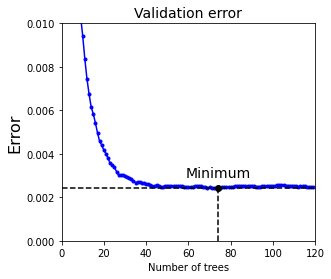

In [120]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

In [121]:
gbrt=GradientBoostingRegressor(max_depth=2,warm_start=True)

min_val_error=float("inf")
error_going_up=0
for n_estimators in range(1,120):
  gbrt.n_estimators=n_estimators
  gbrt.fit(x_train,y_train)
  y_pred=gbrt.predict(x_val)
  val_error=mean_squared_error(y_val,y_pred)
  if val_error < min_val_error:
    min_val_error=val_error
    error_going_up=0
  else:
    error_going_up+=1
    if error_going_up==5:
      break

### 스태킹
* 앙상블에 속한 모든 예측기의 예측을 취합하는 모델을 훈련시키는 방법?!
* 회귀 모델 여러개의 결과값을 취합해서 최종 예측을 만드는 모델!(최종 예측기를 블렌더 또는 메타학습기라 부름)
*홀드아웃 세트를 이용한다.
  * 훈련세트를 두개의 서브셋으로 나눈다.
    * 첫번째 서브셋은 레이어의 예측을 훈련시키기 위해 사용된다.
    * 첫번째 레이어의 예측기를 사용해 두번째 세트의 예측을 만든다.
    * 첫번째 세트의 결과를 취합하는 두번째 세트의 블렌더를 통해 최종 예측을 진행한다.